In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import pickle
from omegaconf import DictConfig, OmegaConf

In [2]:
# 将 MScProject 目录添加到 Python 模块搜索路径
sys.path.append(os.path.abspath('..'))
# 从 DataGenerate.py 导入 DataGenerate 类 用于pickle导入
from DataGenerate import TrainValidManage


In [3]:
# 加载 config.yaml 文件
main_config = OmegaConf.load("../config/config.yaml")

# 打印完整的配置内容
print(OmegaConf.to_yaml(main_config))

base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
data_generation:
  load_data:
    node_mean: 50.0
    node_var: 10.0
    node_iid_var: 5.0
    node_theta: 0.9
  latency:
    mean: 0.0
    var: 0.0
    iid_var: 0.0
    theta: 0.0
exp4:
  batch_size: 64
  seq_length: 20
  input_size: 10
  output_size: 10
  learning_rate: 0.001
  num_workers: 24
  num_epochs: 100
  device: cuda
  mix_precision: true
  patience_epochs: 6
  min_delta: 0.001
  mode: min
  factor: 0.1
  patience_lr: 2
  min_lr: 1.0e-06
  threshold: 0.01
  ARconfig:
    order: 5
  LSTMconfig:
    hidden_size: 128
    num_layers: 4
    dropout_prob: 0.2
  GNNconfig:
    hidden_size: 128
    num_layers: 4



In [4]:
# # 明确添加安全的全局对象, 用于防止导入pickle时的警告信息
# torch.serialization.add_safe_globals({"TrainValidManage": TrainValidManage})

# 从文件加载对象
with open('../Data/ar1_data_train_val_manage.pkl', 'rb') as f:
    ar1_data_train_val_manage = pickle.load(f)
    
# 从文件加载对象
with open('../Data/iid_data_train_val_manage.pkl', 'rb') as f:
    iid_data_train_val_manage = pickle.load(f)

/usr/local/Anaconda3/envs/MScProject/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


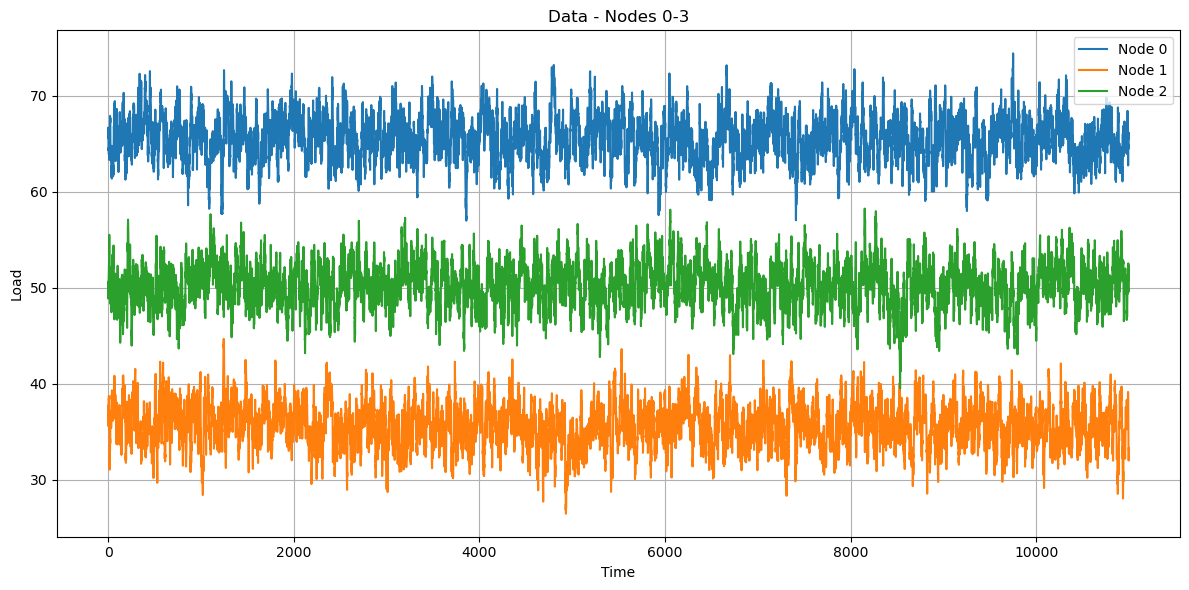

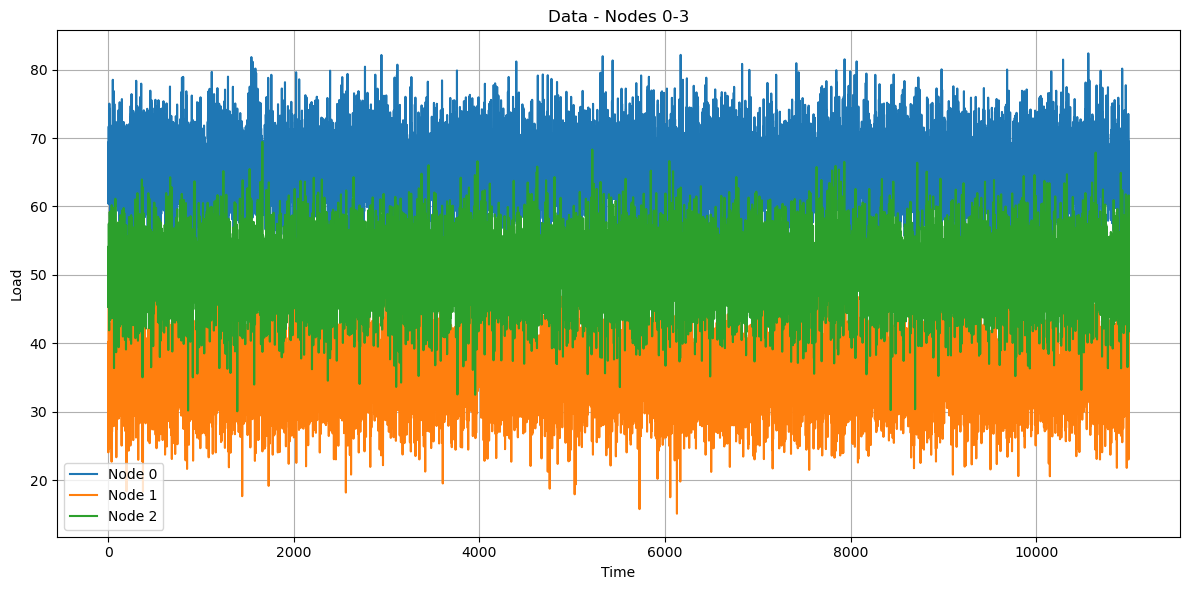

In [5]:
ar1_data_train_val_manage.plot_range_data(ar1_data_train_val_manage.data_np[:3, :], title='Data')
iid_data_train_val_manage.plot_range_data(iid_data_train_val_manage.data_np[:3, :], title='Data')

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from typing import List, Tuple, Optional
from torch.utils.data import DataLoader
from torch_geometric.nn import GCNConv
import torch.optim.lr_scheduler as lr_scheduler


In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.layer_norm(out[:, -1, :])
        out = F.relu(out)
        out = self.fc(out)
        return out

In [8]:
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob=0.5):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)  # LSTM层
#         self.layer_norm = nn.LayerNorm(hidden_size)  # 层归一化
#         self.dropout = nn.Dropout(dropout_prob)  # Dropout层        
#         self.fc = nn.Linear(hidden_size, output_size)  # 全连接层
# 
#     def forward(self, x):
#         h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h_0, c_0))  # LSTM层的输出
#         out = self.layer_norm(out[:, -1, :])  # 对最后一个时间步进行层归一化
#         out = self.dropout(out)  # 应用Dropout
#         out = F.relu(out)  # 应用ReLU激活函数
#         out = self.fc(out)  # 全连接层输出
# 
#         return out


In [9]:
class EarlyStopping:
    def __init__(self, patience_epochs=5, min_delta=1e-2):
        self.patience_epochs = patience_epochs
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, train_loss):
        if self.best_loss is None:
            self.best_loss = train_loss
        elif train_loss < self.best_loss - self.min_delta:
            self.best_loss = train_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience_epochs:
                self.early_stop = True

In [10]:
class LSTMTraining:
    def __init__(self, config: dict, data_manage: object) -> None:
        # 从 config 提取基础参数
        self.T_train: int = config['base']['T_train']
        self.T_val: int = config['base']['T_val']
        self.T_test: int = config['base']['T_test']

        # 从 config 提取 LSTM 模型参数
        
        self.seq_length: int = config['exp4']['seq_length']
        self.input_size: int = config['exp4']['input_size']
        self.output_size: int = config['exp4']['output_size']

        self.num_epochs: int = config['exp4']['num_epochs']
        self.device: str = config['exp4']['device']
        self.mix_precision: bool = config['exp4']['mix_precision']
        
        self.model: nn.Module = LSTMModel(
            input_size=self.input_size,
            hidden_size=config['exp4']['LSTMconfig']['hidden_size'],
            output_size=self.output_size,
            num_layers=config['exp4']['LSTMconfig']['num_layers'],
            # dropout_prob=config['exp4']['LSTMconfig']['dropout_prob']
        ).to(self.device)

        # 优化器、损失函数、学习率调度器、早停
        self.criterion: nn.Module = nn.MSELoss()
        self.optimizer: optim.Optimizer = optim.Adam(self.model.parameters(), lr=config['exp4']['learning_rate'])
        self.scheduler: lr_scheduler.ReduceLROnPlateau = lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode=config['exp4']['mode'],
            factor=config['exp4']['factor'],
            patience=config['exp4']['patience_lr'],
            min_lr=config['exp4']['min_lr'],
            threshold=config['exp4']['threshold']
        )
        self.early_stopping: EarlyStopping = EarlyStopping(patience_epochs=config['exp4']['patience_epochs'], min_delta=config['exp4']['min_delta'])
        self.scaler: Optional[torch.amp.GradScaler] = torch.amp.GradScaler() if config['exp4']['mix_precision'] else None

        # 数据管理
        self.train_dataloader: DataLoader = data_manage.train_dataloader
        self.val_dataloader: DataLoader = data_manage.val_dataloader
        self.test_data_tensor: torch.Tensor = data_manage.test_data_tensor
        
        # 获取完整tarin_val的tensor数据，用于截取最后一组，对test的第一个进行预测
        self.train_val_data_tensor: torch.Tensor = data_manage.train_val_data_tensor
        
        self.train_data_np: np.ndarray = data_manage.train_data_np
        self.val_data_np: np.ndarray = data_manage.val_data_np
        self.test_data_np: np.ndarray = data_manage.test_data_np

        # # 从 data_manage 模块中获取边索引张量
        # edge_index = data_manage.edge_index_tensor

        # 用于记录预测值
        self.train_predictions: Optional[torch.Tensor] = None
        self.val_predictions: Optional[torch.Tensor] = None
        self.test_predictions: Optional[torch.Tensor] = None
        
        # 记录损失
        self.train_losses: List[float] = []
        self.val_losses: List[float] = []
        self.fine_tune_losses: List[float] = []

        # 记录学习率变化
        self.train_with_val_learning_rates: List[float] = []
        self.fine_tune_learning_rates: List[float] = []

        # 记录扩展的学习率
        self.train_extended_lr: Optional[np.ndarray] = None
        self.val_extended_lr: Optional[np.ndarray] = None

    def train_epoch(self, epoch: int) -> Tuple[float, torch.Tensor]:
        self.model.train()  # Ensure model is in training mode
        train_cumulative_loss: float = 0.0  # 训练集累积损失
        epoch_train_pred: torch.Tensor = torch.zeros((self.T_train, self.output_size), device=self.device)
        train_start_idx: int = 20  # 预测初始index值

        for train, val in self.train_dataloader:
            batch_size: int = train.size(0)
            end_idx: int = train_start_idx + batch_size
            train, val = train.to(self.device, non_blocking=True).float(), val.to(self.device, non_blocking=True).float()

            self.optimizer.zero_grad()  # Reset gradients

            if self.mix_precision:  # Mixed precision training
                with torch.amp.autocast(device_type=self.device):
                    train_pred: torch.Tensor = self.model(train)  # 前向传播, shape: [batch_size, output_size], [64, 10]
                    train_loss: torch.Tensor = self.criterion(train_pred, val)
                self.scaler.scale(train_loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                train_pred: torch.Tensor = self.model(train)
                train_loss: torch.Tensor = self.criterion(train_pred, val)
                train_loss.backward()
                self.optimizer.step()

            # 将当前批次的预测结果填入对应位置
            epoch_train_pred[train_start_idx:end_idx] = train_pred.detach()
            # print(f'Train start index: {train_start_idx}, End index: {end_idx}')
            train_start_idx = end_idx
            self.train_losses.append(train_loss.item())    # Record single training loss
            train_cumulative_loss += train_loss.item()

        return train_cumulative_loss, epoch_train_pred

    def validate_epoch(self) -> Tuple[float, torch.Tensor]:
        self.model.eval()  # Ensure model is in evaluation mode
        val_cumulative_loss: float = 0.0
        epoch_val_pred: torch.Tensor = torch.zeros((self.T_val, self.output_size), device=self.device)
        val_start_idx: int = 0  # 预测值起始位置
        
        with torch.no_grad():
            for val_input, val_target in self.val_dataloader:
                batch_size: int = val_input.size(0)
                
                end_idx: int = val_start_idx + batch_size

                val_input, val_target = val_input.to(self.device, non_blocking=True).float(), val_target.to(self.device, non_blocking=True).float()

                if self.mix_precision: # 混合精度推断
                    with torch.amp.autocast(device_type=self.device):
                        val_pred: torch.Tensor = self.model(val_input)
                        val_loss: torch.Tensor = self.criterion(val_pred, val_target)
                else:
                    val_pred: torch.Tensor = self.model(val_input)
                    val_loss: torch.Tensor = self.criterion(val_pred, val_target)

                # 将当前批次的预测结果填入对应位置
                epoch_val_pred[val_start_idx:end_idx] = val_pred.detach()
                val_start_idx = end_idx  # 更新起始索引
                self.val_losses.append(val_loss.item())  # Record single validation loss
                val_cumulative_loss += val_loss.item()

        return val_cumulative_loss, epoch_val_pred

    def train(self) -> None:
        for epoch in tqdm(range(self.num_epochs), desc="Training"):
            train_cumulative_loss, epoch_train_pred = self.train_epoch(epoch)
            val_cumulative_loss, epoch_val_pred = self.validate_epoch()

            # 计算训练和验证的平均损失
            train_avg_loss: float = train_cumulative_loss / len(self.train_dataloader)
            val_avg_loss: float = val_cumulative_loss / len(self.val_dataloader)

            # 早停机制基于验证集损失
            self.early_stopping(val_avg_loss)
            if self.early_stopping.early_stop:
                print(f"Early stopping triggered. Stopping training. Epoch: {epoch + 1}")
                break

            # 调度器更新基于验证集损失
            self.scheduler.step(val_avg_loss)
            
            # 动态学习率
            current_lr: float = self.scheduler.optimizer.param_groups[0]['lr']
            self.train_with_val_learning_rates.append(current_lr)

            if (epoch + 1) % 10 == 0:  # 每10轮输出一次损失, 以及释放GPU缓存
                print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train_Loss: {train_avg_loss:.4f}, Val_Loss: {val_avg_loss:.4f}')
                print(f'Current Learning Rate: {current_lr:.6f}')

                # if torch.cuda.is_available():  # 释放GPU缓存
                #     torch.cuda.empty_cache()

        self.train_predictions = epoch_train_pred
        self.val_predictions = epoch_val_pred

        # 训练结束后计算扩展的学习率
        self.compute_extended_learning_rates()

        print(f"Training finished after {epoch + 1} epochs.")
        print(f"Average loss per epoch: {train_avg_loss:.4f}, Validation loss: {val_avg_loss:.4f}")

    def fine_tune(self) -> None:
        tune_cumulative_loss: float = 0.0
        predictions: torch.Tensor = torch.zeros((self.T_test, self.output_size), device=self.device)
        input_data: torch.Tensor = self.train_val_data_tensor[:, -self.seq_length:].T.unsqueeze(0).to(self.device)

        for i in tqdm(range(self.T_test), desc="Predicting and Fine-tuning"):
            self.model.train()  # Keep model in training mode for fine-tuning
            pred: torch.Tensor = self.model(input_data)
            predictions[i] = pred.squeeze(0)  # 将预测值保存到 predictions, shape: [T_test, output_size], [1000, 10]


            loss: torch.Tensor = self.criterion(pred.squeeze(0), self.test_data_tensor[:, i])    # 计算损失
            self.fine_tune_losses.append(loss.item())    # 记录单次损失
            tune_cumulative_loss += loss.item()    # 累加损失

            # 使用真实值进行微调
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # 在每个epoch结束时，计算验证集的平均损失
            tune_avg_loss: float = tune_cumulative_loss / (i + 1)

            # 调度器更新（可选，基于微调期间的损失）
            self.scheduler.step(tune_avg_loss)
            current_lr: float = self.scheduler.get_last_lr()[0]
            self.fine_tune_learning_rates.append(current_lr)

            if (i + 1) % 100 == 0:  # 每100步输出一次损失
                print(f'Step {i + 1}/{self.T_test}, Loss: {tune_avg_loss:.4f}')
                print(f'Current Learning Rate: {current_lr:.6f}')
            
            # 更新输入序列 
            input_data = torch.cat((input_data[:, 1:, :], self.test_data_tensor[:, i].unsqueeze(0).unsqueeze(1)), dim=1)

        print(f'Average Fine-tuning Loss over {self.T_test} steps: {tune_avg_loss:.4f}')
        self.test_predictions = predictions
        
    def compute_extended_learning_rates(self) -> None:
        """计算用于绘图的扩展学习率数组"""
        train_steps = len(self.train_losses)
        val_steps = len(self.val_losses)
        num_epochs = len(self.train_with_val_learning_rates)

        train_repeats_per_epoch = train_steps // num_epochs
        val_repeats_per_epoch = val_steps // num_epochs

        self.train_extended_lr = np.repeat(self.train_with_val_learning_rates, train_repeats_per_epoch)
        train_remaining_steps = train_steps - len(self.train_extended_lr)
        if train_remaining_steps > 0:
            self.train_extended_lr = np.append(self.train_extended_lr, [self.train_with_val_learning_rates[-1]] * train_remaining_steps)

        self.val_extended_lr = np.repeat(self.train_with_val_learning_rates, val_repeats_per_epoch)
        val_remaining_steps = val_steps - len(self.val_extended_lr)
        if val_remaining_steps > 0:
            self.val_extended_lr = np.append(self.val_extended_lr, [self.train_with_val_learning_rates[-1]] * val_remaining_steps)

    def plot_loss(self) -> None:
        """绘制训练和验证的损失曲线"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Train Losses')
        plt.plot(self.val_losses, label='Validation Losses')
        plt.title('Training and Validation Loss over Time')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_loss_and_lr(self) -> None:
        """同时绘制训练损失、验证损失和学习率变化曲线"""
        fig, ax1 = plt.subplots(figsize=(12, 6))
    
        color = 'tab:red'
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss', color=color)
        ax1.plot(range(len(self.train_losses)), self.train_losses, label='Train Loss', color='tab:red')
        ax1.plot(range(len(self.val_losses)), self.val_losses, label='Val Loss', color='tab:orange')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.legend(loc='upper left')
    
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Learning Rate', color=color)
        ax2.plot(range(len(self.train_with_val_learning_rates)), self.train_with_val_learning_rates, label='Training LR', linestyle='--', color='tab:blue')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc='upper right')
    
        fig.tight_layout()
        plt.title('Loss and Learning Rate over Time')
        plt.grid(True)
        plt.show()

    def plot_full(self, i: int) -> None:
        """绘制完整的训练、验证和测试集的预测与实际值对比图"""
        plt.figure(figsize=(15, 6))

        # 绘制训练集预测与实际值
        plt.plot(range(self.T_train), self.train_predictions[:, i].detach().cpu().numpy(), label='Train Predictions', linestyle='--')
        plt.plot(range(self.T_train), self.train_data_np[i, :], label='Train Actual')

        # 绘制验证集预测与实际值
        plt.plot(range(self.T_train, self.T_train + self.T_val), self.val_predictions[:, i].detach().cpu().numpy(), label='Val Predictions', linestyle='--')
        plt.plot(range(self.T_train, self.T_train + self.T_val), self.val_data_np[i, :], label='Val Actual')

        # 绘制测试集预测与实际值
        plt.plot(range(self.T_train + self.T_val, self.T_train + self.T_val + self.T_test), self.test_predictions[:, i].detach().cpu().numpy(), label='Test Predictions', linestyle='--')
        plt.plot(range(self.T_train + self.T_val, self.T_train + self.T_val + self.T_test), self.test_data_np[i, :], label='Test Actual')

        # 标记训练集、验证集和测试集的边界
        plt.axvline(x=self.T_train, color='black', linestyle='--', label='Train/Val Boundary')
        plt.axvline(x=self.T_train + self.T_val, color='black', linestyle='--', label='Val/Test Boundary')

        plt.legend()
        plt.title('Full Prediction vs Actual')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_train(self, i: int) -> None:
        """绘制训练集的预测与实际值对比图"""
        plt.figure(figsize=(15, 6))

        # 绘制训练集预测与实际值
        plt.plot(range(self.T_train), self.train_predictions[:, i].detach().cpu().numpy(), label='Train Predictions', linestyle='--')
        plt.plot(range(self.T_train), self.train_data_np[i, :], label='Train Actual')

        plt.legend()
        plt.title('Train Prediction vs Actual')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_val(self, i: int) -> None:
        """绘制验证集的预测与实际值对比图"""
        plt.figure(figsize=(15, 6))

        # 绘制验证集预测与实际值
        plt.plot(range(self.T_val), self.val_predictions[:, i].detach().cpu().numpy(), label='Val Predictions', linestyle='--')
        plt.plot(range(self.T_val), self.val_data_np[i, :], label='Val Actual')

        plt.legend()
        plt.title('Validation Prediction vs Actual')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_test(self, i: int) -> None:
        """绘制测试集的预测与实际值对比图"""
        plt.figure(figsize=(15, 6))

        # 绘制测试集预测与实际值
        plt.plot(range(self.T_test), self.test_predictions[:, i].detach().cpu().numpy(), label='Test Predictions', linestyle='--')
        plt.plot(range(self.T_test), self.test_data_np[i, :], label='Test Actual')

        plt.legend()
        plt.title('Test Prediction vs Actual')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_range(self, start: int, end: int, i: int) -> None:
        """在指定范围内绘制预测值与实际值的对比图"""
        total_length = self.T_train + self.T_val + self.T_test
        if start < 0 or end > total_length or start >= end:
            raise ValueError(f"Invalid range: start={start}, end={end}. Check the range values.")

        # 拼接训练、验证和测试集的预测结果
        full_data = torch.cat([self.train_predictions.detach(), self.val_predictions.detach(), self.test_predictions.detach()], dim=0).cpu().numpy()
        full_actual = np.concatenate([self.train_data_np, self.val_data_np, self.test_data_np], axis=1)

        if i < 0 or i >= full_actual.shape[0]:
            raise ValueError(f"Invalid node index: i={i}. Check the node index.")

        plt.figure(figsize=(15, 6))

        # 在指定范围内绘制第 i 个节点的预测值与实际值
        plt.plot(range(start, end), full_data[start:end, i], label='Predictions', linestyle='--')
        plt.plot(range(start, end), full_actual[i, start:end], label='Actual')

        plt.legend()
        plt.title(f'Prediction vs Actual for Node {i} from {start} to {end}')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_all_losses_and_lr_0(self) -> None:
        """绘制训练、验证、微调的损失和学习率曲线"""
        if self.train_extended_lr is None or self.val_extended_lr is None:
            raise ValueError("Learning rates have not been computed. Call compute_extended_learning_rates() first.")

        fig, axs = plt.subplots(3, 3, figsize=(18, 15))

        # 训练集的单次损失、累积损失和学习率
        axs[0, 0].plot(self.train_losses, label='Train Losses')
        axs[0, 0].set_title('Train Losses over Time')
        axs[0, 0].set_xlabel('Steps')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].legend()

        cumulative_train_losses = np.cumsum(self.train_losses)
        axs[0, 1].plot(cumulative_train_losses, label='Cumulative Train Losses')
        axs[0, 1].set_title('Cumulative Train Losses over Time')
        axs[0, 1].set_xlabel('Steps')
        axs[0, 1].set_ylabel('Cumulative Loss')
        axs[0, 1].legend()

        axs[0, 2].plot(self.train_extended_lr, label='Train Learning Rate')
        axs[0, 2].set_title('Train Learning Rate over Time')
        axs[0, 2].set_xlabel('Steps')
        axs[0, 2].set_ylabel('Learning Rate')
        axs[0, 2].legend()

        # 验证集的单次损失、累积损失和学习率
        axs[1, 0].plot(self.val_losses, label='Val Losses')
        axs[1, 0].set_title('Val Losses over Time')
        axs[1, 0].set_xlabel('Steps')
        axs[1, 0].set_ylabel('Loss')
        axs[1, 0].legend()

        cumulative_val_losses = np.cumsum(self.val_losses)
        axs[1, 1].plot(cumulative_val_losses, label='Cumulative Val Losses')
        axs[1, 1].set_title('Cumulative Val Losses over Time')
        axs[1, 1].set_xlabel('Steps')
        axs[1, 1].set_ylabel('Cumulative Loss')
        axs[1, 1].legend()

        axs[1, 2].plot(self.val_extended_lr, label='Val Learning Rate')
        axs[1, 2].set_title('Val Learning Rate over Time')
        axs[1, 2].set_xlabel('Steps')
        axs[1, 2].set_ylabel('Learning Rate')
        axs[1, 2].legend()

        # 微调测试集的单次损失、累积损失和学习率
        axs[2, 0].plot(self.fine_tune_losses, label='Fine-tune Losses')
        axs[2, 0].set_title('Fine-tune Losses over Time')
        axs[2, 0].set_xlabel('Steps')
        axs[2, 0].set_ylabel('Loss')
        axs[2, 0].legend()

        cumulative_fine_tune_losses = np.cumsum(self.fine_tune_losses)
        axs[2, 1].plot(cumulative_fine_tune_losses, label='Cumulative Fine-tune Losses')
        axs[2, 1].set_title('Cumulative Fine-tune Losses over Time')
        axs[2, 1].set_xlabel('Steps')
        axs[2, 1].set_ylabel('Cumulative Loss')
        axs[2, 1].legend()

        axs[2, 2].plot(self.fine_tune_learning_rates, label='Fine-tune Learning Rate')
        axs[2, 2].set_title('Fine-tune Learning Rate over Time')
        axs[2, 2].set_xlabel('Steps')
        axs[2, 2].set_ylabel('Learning Rate')
        axs[2, 2].legend()

        plt.tight_layout()
        plt.show()

    def plot_all_losses_and_lr_1(self, left_log_scale: bool = True, right_log_scale: bool = True) -> None:
        """绘制训练、验证、微调的损失和学习率曲线，并可选择是否使用对数标尺"""
        fig, axs = plt.subplots(3, 2, figsize=(18, 15))  # 2列布局

        # 训练集的单次损失和学习率
        ax1 = axs[0, 0]
        ax2 = ax1.twinx()
        ax1.plot(self.train_losses, label='Train Losses', color='blue')
        ax2.plot(self.train_extended_lr, label='Train Learning Rate', color='red', linestyle='--')
        ax1.set_title('Train Losses and Learning Rate over Time')
        ax1.set_xlabel('Steps')
        ax1.set_ylabel('Loss')
        ax2.set_ylabel('Learning Rate')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        if left_log_scale:
            ax1.set_yscale('log')  # 左侧轴设置为对数尺度
        if right_log_scale:
            ax2.set_yscale('log')  # 右侧轴设置为对数尺度
        ax2.set_ylim([min(self.train_extended_lr) * 0.95, max(self.train_extended_lr) * 1.1])

        # 训练集的累积损失和学习率
        ax3 = axs[0, 1]
        ax4 = ax3.twinx()
        cumulative_train_losses = np.cumsum(self.train_losses)
        ax3.plot(cumulative_train_losses, label='Cumulative Train Losses', color='blue')
        ax4.plot(self.train_extended_lr, label='Train Learning Rate', color='red', linestyle='--')
        ax3.set_title('Cumulative Train Losses and Learning Rate over Time')
        ax3.set_xlabel('Steps')
        ax3.set_ylabel('Cumulative Loss')
        ax4.set_ylabel('Learning Rate')
        ax3.legend(loc='upper left')
        ax4.legend(loc='upper right')
        if left_log_scale:
            ax3.set_yscale('log')  # 左侧轴设置为对数尺度
        if right_log_scale:
            ax4.set_yscale('log')  # 右侧轴设置为对数尺度
        ax4.set_ylim([min(self.train_extended_lr) * 0.95, max(self.train_extended_lr) * 1.1])

        # 验证集的单次损失和学习率
        ax5 = axs[1, 0]
        ax6 = ax5.twinx()
        ax5.plot(self.val_losses, label='Val Losses', color='blue')
        ax6.plot(self.val_extended_lr, label='Val Learning Rate', color='red', linestyle='--')
        ax5.set_title('Val Losses and Learning Rate over Time')
        ax5.set_xlabel('Steps')
        ax5.set_ylabel('Loss')
        ax6.set_ylabel('Learning Rate')
        ax5.legend(loc='upper left')
        ax6.legend(loc='upper right')
        if left_log_scale:
            ax5.set_yscale('log')  # 左侧轴设置为对数尺度
        if right_log_scale:
            ax6.set_yscale('log')  # 右侧轴设置为对数尺度
        ax6.set_ylim([min(self.val_extended_lr) * 0.95, max(self.val_extended_lr) * 1.1])

        # 验证集的累积损失和学习率
        ax7 = axs[1, 1]
        ax8 = ax7.twinx()
        cumulative_val_losses = np.cumsum(self.val_losses)
        ax7.plot(cumulative_val_losses, label='Cumulative Val Losses', color='blue')
        ax8.plot(self.val_extended_lr, label='Val Learning Rate', color='red', linestyle='--')
        ax7.set_title('Cumulative Val Losses and Learning Rate over Time')
        ax7.set_xlabel('Steps')
        ax7.set_ylabel('Cumulative Loss')
        ax8.set_ylabel('Learning Rate')
        ax7.legend(loc='upper left')
        ax8.legend(loc='upper right')
        if left_log_scale:
            ax7.set_yscale('log')  # 左侧轴设置为对数尺度
        if right_log_scale:
            ax8.set_yscale('log')  # 右侧轴设置为对数尺度
        ax8.set_ylim([min(self.val_extended_lr) * 0.95, max(self.val_extended_lr) * 1.1])

        # 微调阶段的单次损失和学习率
        ax9 = axs[2, 0]
        ax10 = ax9.twinx()
        ax9.plot(self.fine_tune_losses, label='Fine-tune Losses', color='blue')
        ax10.plot(self.fine_tune_learning_rates, label='Fine-tune Learning Rate', color='red', linestyle='--')
        ax9.set_title('Fine-tune Losses and Learning Rate over Time')
        ax9.set_xlabel('Steps')
        ax9.set_ylabel('Loss')
        ax10.set_ylabel('Learning Rate')
        ax9.legend(loc='upper left')
        ax10.legend(loc='upper right')
        if left_log_scale:
            ax9.set_yscale('log')  # 左侧轴设置为对数尺度
        if right_log_scale:
            ax10.set_yscale('log')  # 右侧轴设置为对数尺度
        ax10.set_ylim([min(self.fine_tune_learning_rates) * 0.95, max(self.fine_tune_learning_rates) * 1.05])

        # 微调阶段的累积损失和学习率
        ax11 = axs[2, 1]
        ax12 = ax11.twinx()
        cumulative_fine_tune_losses = np.cumsum(self.fine_tune_losses)
        ax11.plot(cumulative_fine_tune_losses, label='Cumulative Fine-tune Losses', color='blue')
        ax12.plot(self.fine_tune_learning_rates, label='Fine-tune Learning Rate', color='red', linestyle='--')
        ax11.set_title('Cumulative Fine-tune Losses and Learning Rate over Time')
        ax11.set_xlabel('Steps')
        ax11.set_ylabel('Cumulative Loss')
        ax12.set_ylabel('Learning Rate')
        ax11.legend(loc='upper left')
        ax12.legend(loc='upper right')
        if left_log_scale:
            ax11.set_yscale('log')  # 左侧轴设置为对数尺度
        if right_log_scale:
            ax12.set_yscale('log')  # 右侧轴设置为对数尺度
        ax12.set_ylim([min(self.fine_tune_learning_rates) * 0.95, max(self.fine_tune_learning_rates) * 1.05])

        plt.tight_layout()
        plt.show()

In [11]:
config = main_config
data_manage = ar1_data_train_val_manage

In [12]:
lstm_trainer = LSTMTraining(config, data_manage)

In [13]:
lstm_trainer.train()

Training:  10%|█         | 10/100 [00:16<02:29,  1.66s/it]

Epoch [10/100], Train_Loss: 5.1696, Val_Loss: 5.0101
Current Learning Rate: 0.001000


Training:  20%|██        | 20/100 [00:32<02:10,  1.63s/it]

Epoch [20/100], Train_Loss: 3.7012, Val_Loss: 3.7424
Current Learning Rate: 0.001000


Training:  30%|███       | 30/100 [00:49<01:57,  1.68s/it]

Epoch [30/100], Train_Loss: 1.6160, Val_Loss: 2.2288
Current Learning Rate: 0.001000


Training:  40%|████      | 40/100 [01:06<01:44,  1.75s/it]

Epoch [40/100], Train_Loss: 1.0807, Val_Loss: 1.8482
Current Learning Rate: 0.000100


Training:  43%|████▎     | 43/100 [01:13<01:37,  1.71s/it]

Early stopping triggered. Stopping training. Epoch: 44
Training finished after 44 epochs.
Average loss per epoch: 1.0593, Validation loss: 1.8503


In [14]:
data_manage.print_dataloader_info(data_manage.train_dataloader, 'train')

---------- train Dataloader Info ----------
Batch      x.min    x.max    y.min    y.max    x.shape:torch.Size y.shape:torch.Size
    1/125   27.6869  73.1877  30.1238  72.2139  [64, 20, 10]       [64, 10]          
   31/125   26.4636  72.2760  29.0704  71.6492  [64, 20, 10]       [64, 10]          
   61/125   28.2834  72.5305  28.8292  71.4549  [64, 20, 10]       [64, 10]          
   91/125   28.1393  72.1405  29.4580  70.3653  [64, 20, 10]       [64, 10]          
  121/125   26.6964  73.1489  29.9481  73.1561  [64, 20, 10]       [64, 10]          
  125/125   24.9115  72.9536  26.4407  71.6744  [44, 20, 10]       [44, 10]          


In [15]:
data_manage.print_dataloader_info(data_manage.val_dataloader, 'val')

---------- val Dataloader Info ----------
Batch      x.min    x.max    y.min    y.max    x.shape:torch.Size y.shape:torch.Size
    1/32    31.1705  72.7515  31.1705  72.7515  [64, 20, 10]       [64, 10]          
   31/32    30.0171  68.4553  30.2066  68.4553  [64, 20, 10]       [64, 10]          
   32/32    32.1922  66.4470  33.1464  65.8987  [16, 20, 10]       [16, 10]          


In [16]:
len(lstm_trainer.train_losses), len(lstm_trainer.val_losses), len(lstm_trainer.train_with_val_learning_rates)

(5500, 1408, 43)

In [17]:
len(lstm_trainer.train_losses)/len(lstm_trainer.train_with_val_learning_rates)

127.90697674418605

In [18]:
len(lstm_trainer.val_losses)/len(lstm_trainer.train_with_val_learning_rates)

32.74418604651163

In [19]:
lstm_trainer.train_predictions

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [66.5000, 33.6250, 48.5938,  ..., 37.1562, 42.6562, 56.9688],
        [64.4375, 37.7812, 50.4062,  ..., 33.6562, 36.7188, 54.1875],
        [63.3125, 33.1250, 51.0625,  ..., 37.4062, 44.0625, 58.7500]],
       device='cuda:0')

In [20]:
lstm_trainer.train_predictions.shape

torch.Size([8000, 10])

In [21]:
lstm_trainer.val_predictions

tensor([[68.2500, 37.3125, 51.6562,  ..., 35.1250, 42.5000, 56.4062],
        [67.4375, 37.3125, 51.1875,  ..., 35.5938, 42.4688, 56.3750],
        [66.7500, 36.0312, 51.2812,  ..., 35.7500, 43.0625, 57.2812],
        ...,
        [64.9375, 37.3750, 48.7500,  ..., 38.3125, 40.7188, 60.0000],
        [66.0625, 36.4062, 47.2812,  ..., 37.5938, 41.5312, 59.8125],
        [66.8750, 37.2188, 46.8125,  ..., 37.3125, 42.1562, 59.9375]],
       device='cuda:0')

In [22]:
lstm_trainer.val_predictions.shape

torch.Size([2000, 10])

In [23]:
lstm_trainer.fine_tune()

Predicting and Fine-tuning:  13%|█▎        | 133/1000 [00:00<00:04, 215.81it/s]

Step 100/1000, Loss: 1.6606
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  26%|██▌       | 262/1000 [00:01<00:02, 303.53it/s]

Step 200/1000, Loss: 1.7235
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  38%|███▊      | 380/1000 [00:01<00:01, 362.37it/s]

Step 300/1000, Loss: 1.6960
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  46%|████▌     | 462/1000 [00:01<00:01, 383.68it/s]

Step 400/1000, Loss: 1.6463
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  54%|█████▍    | 540/1000 [00:02<00:01, 378.01it/s]

Step 500/1000, Loss: 1.6753
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  65%|██████▌   | 652/1000 [00:02<00:00, 352.88it/s]

Step 600/1000, Loss: 1.6506
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  77%|███████▋  | 773/1000 [00:02<00:00, 384.84it/s]

Step 700/1000, Loss: 1.6744
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  85%|████████▌ | 854/1000 [00:02<00:00, 387.42it/s]

Step 800/1000, Loss: 1.6863
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  97%|█████████▋| 969/1000 [00:03<00:00, 363.34it/s]

Step 900/1000, Loss: 1.6962
Current Learning Rate: 0.000001


Predicting and Fine-tuning: 100%|██████████| 1000/1000 [00:03<00:00, 300.74it/s]

Step 1000/1000, Loss: 1.7104
Current Learning Rate: 0.000001
Average Fine-tuning Loss over 1000 steps: 1.7104


In [24]:
lstm_trainer.train_predictions.shape, lstm_trainer.val_predictions.shape, lstm_trainer.test_predictions.shape

(torch.Size([8000, 10]), torch.Size([2000, 10]), torch.Size([1000, 10]))

In [25]:
len(lstm_trainer.train_losses), len(lstm_trainer.val_losses), len(lstm_trainer.fine_tune_losses)

(5500, 1408, 1000)

In [26]:
len(lstm_trainer.train_with_val_learning_rates), len(lstm_trainer.fine_tune_learning_rates)

(43, 1000)

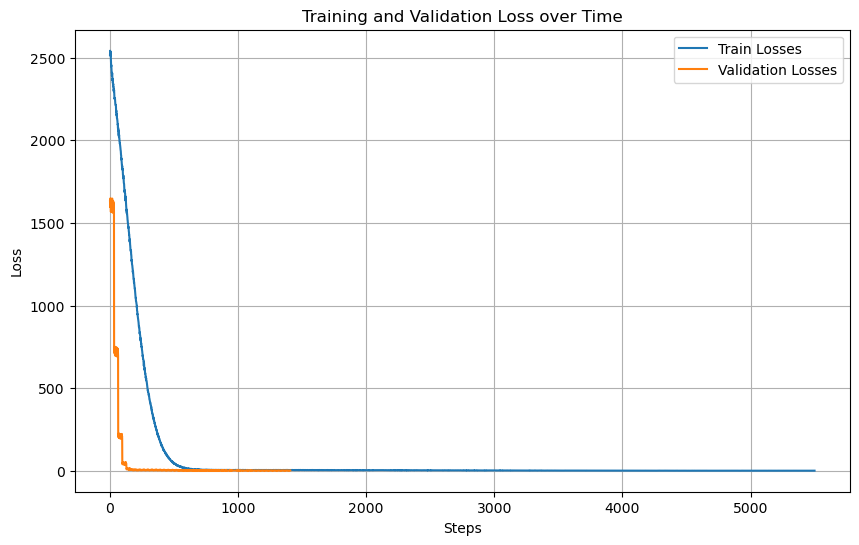

In [27]:
lstm_trainer.plot_loss()  # 绘制训练和验证损失

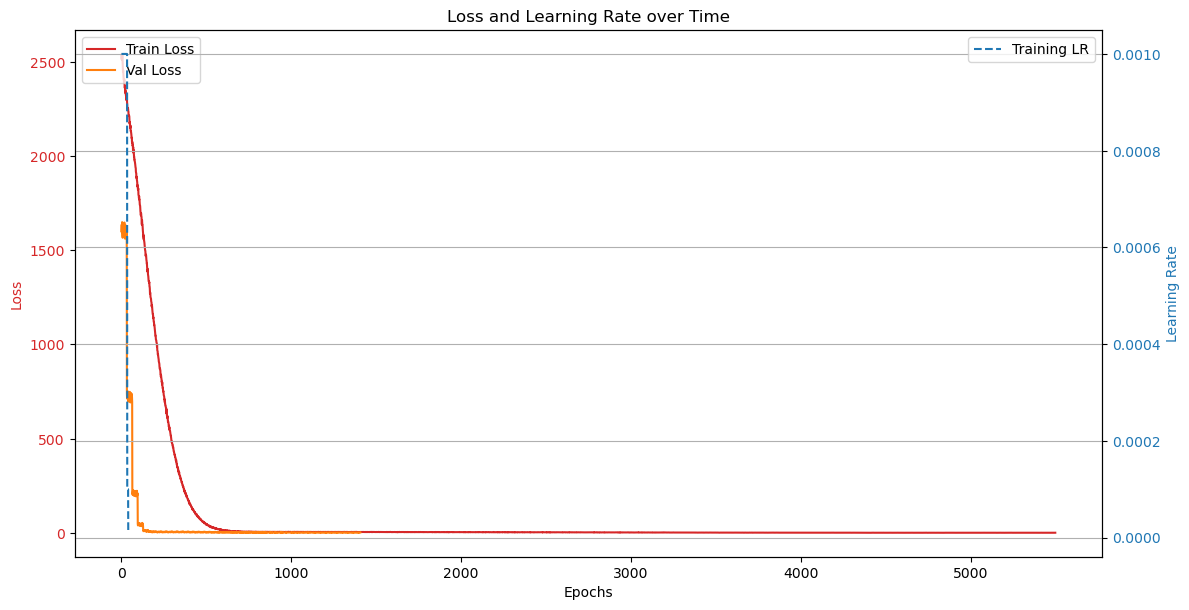

In [28]:
lstm_trainer.plot_loss_and_lr()  # 同时绘制损失和学习率变化曲线

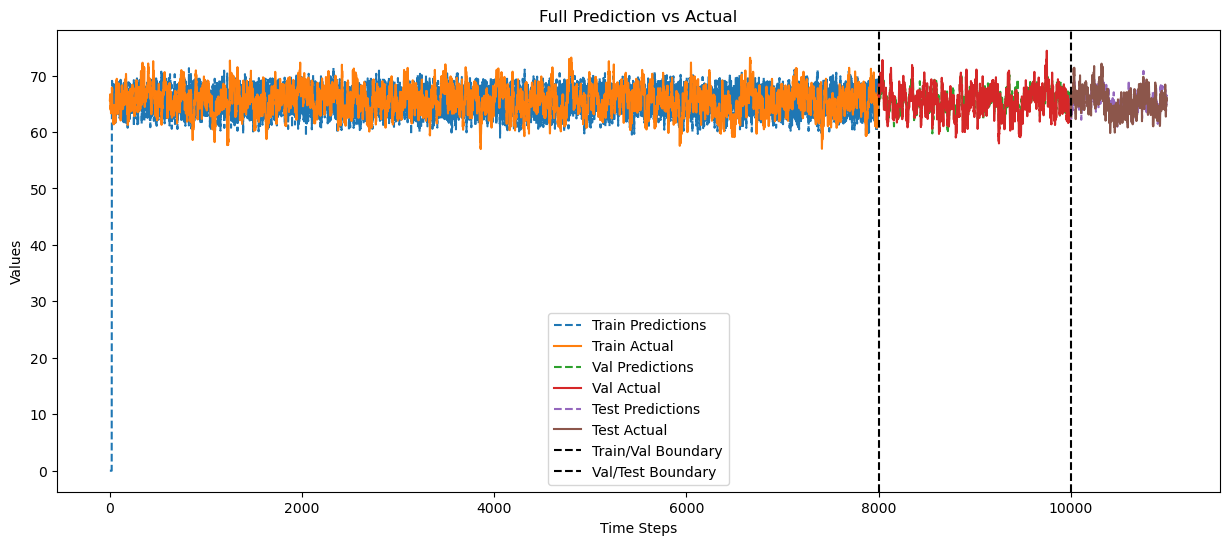

In [29]:
lstm_trainer.plot_full(0)

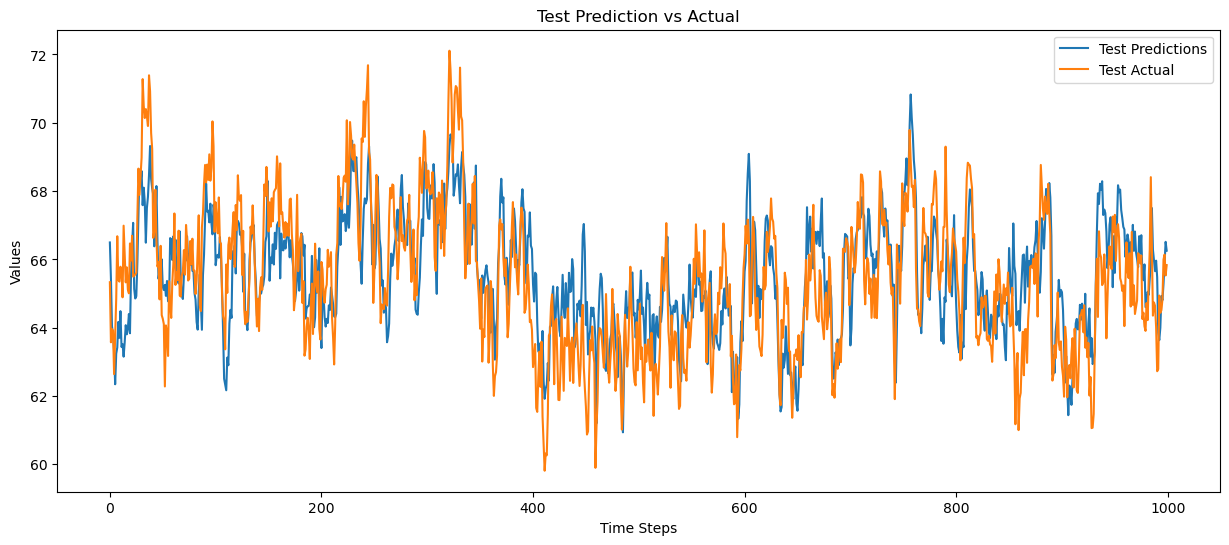

In [30]:
lstm_trainer.plot_test(0)

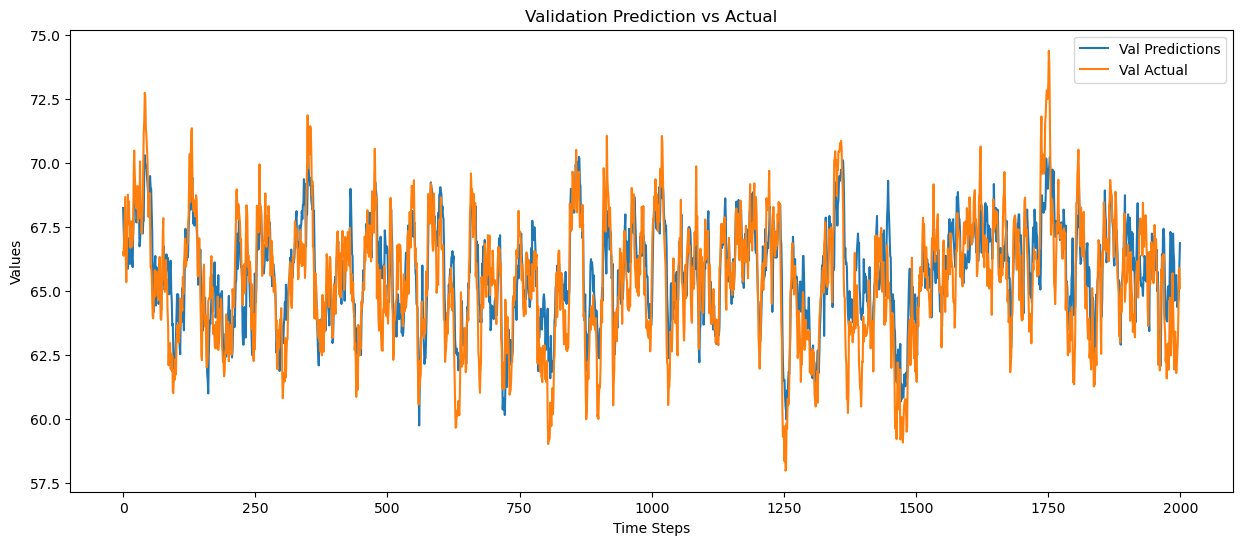

In [31]:
lstm_trainer.plot_val(0)

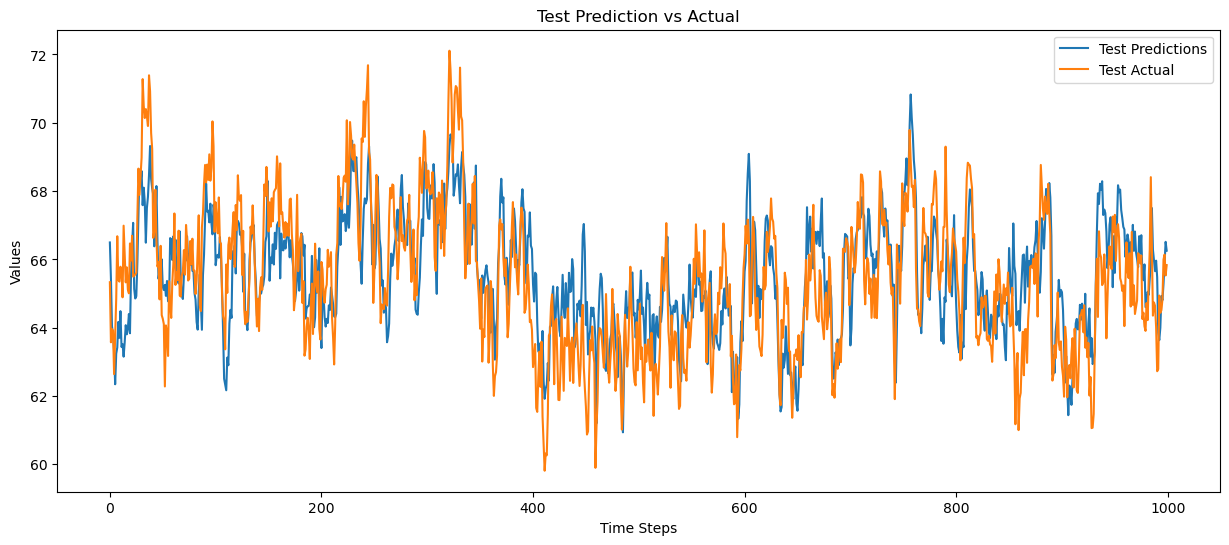

In [32]:
lstm_trainer.plot_test(0)

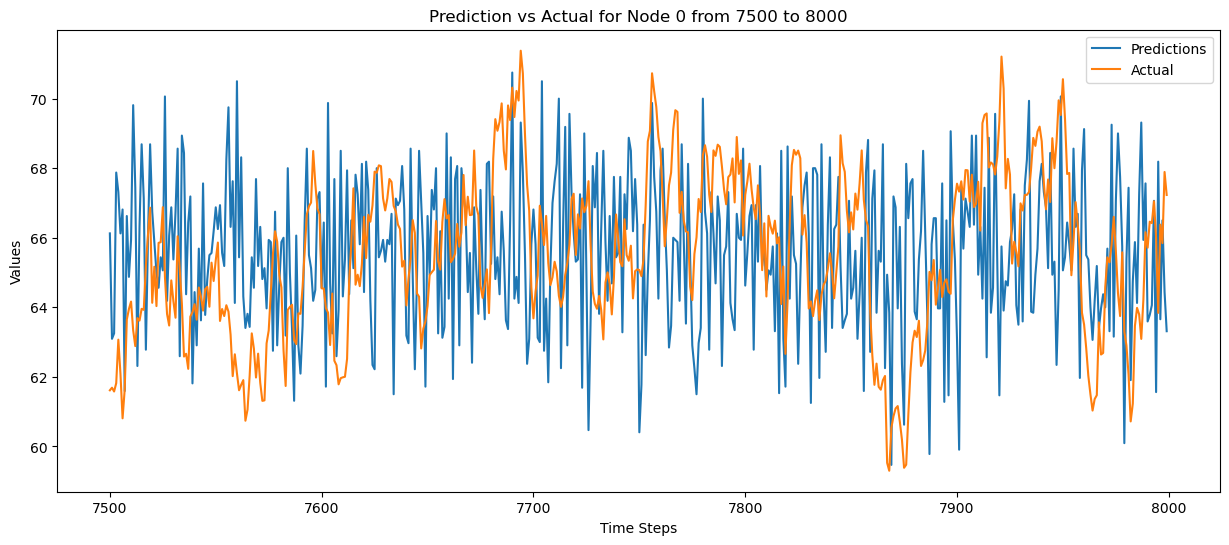

In [33]:
lstm_trainer.plot_range(7500, 8000, 0)

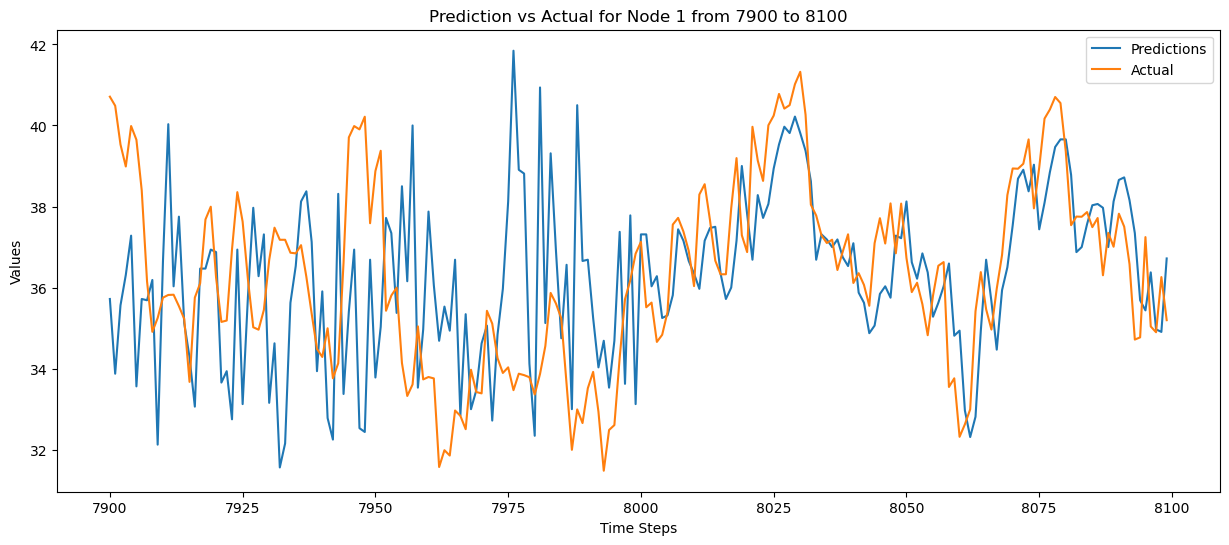

In [34]:
lstm_trainer.plot_range(7900, 8100, 1)

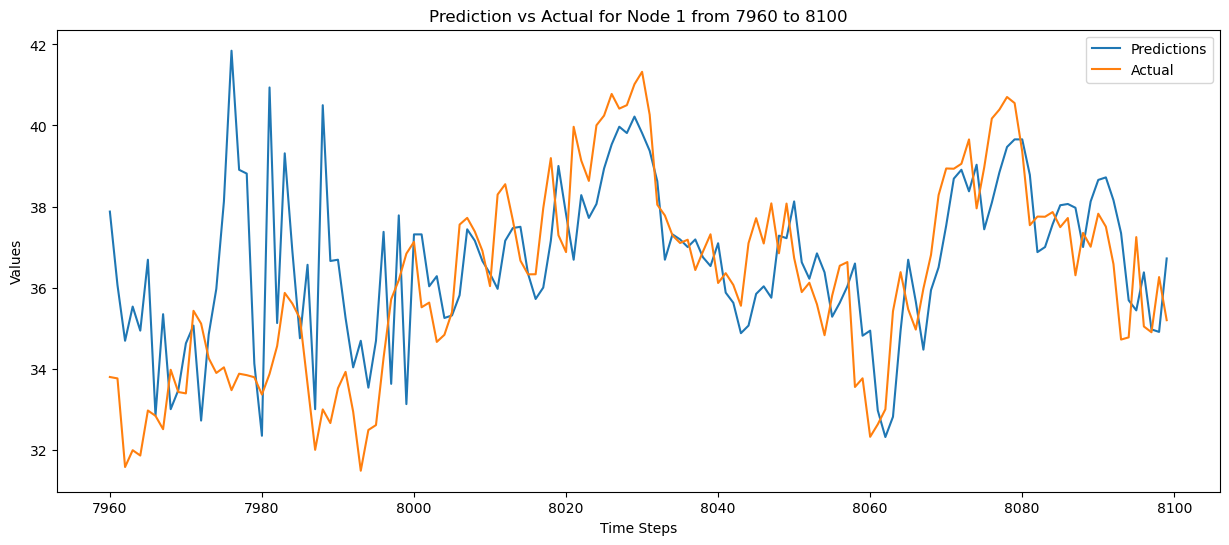

In [35]:
lstm_trainer.plot_range(7960, 8100, 1)

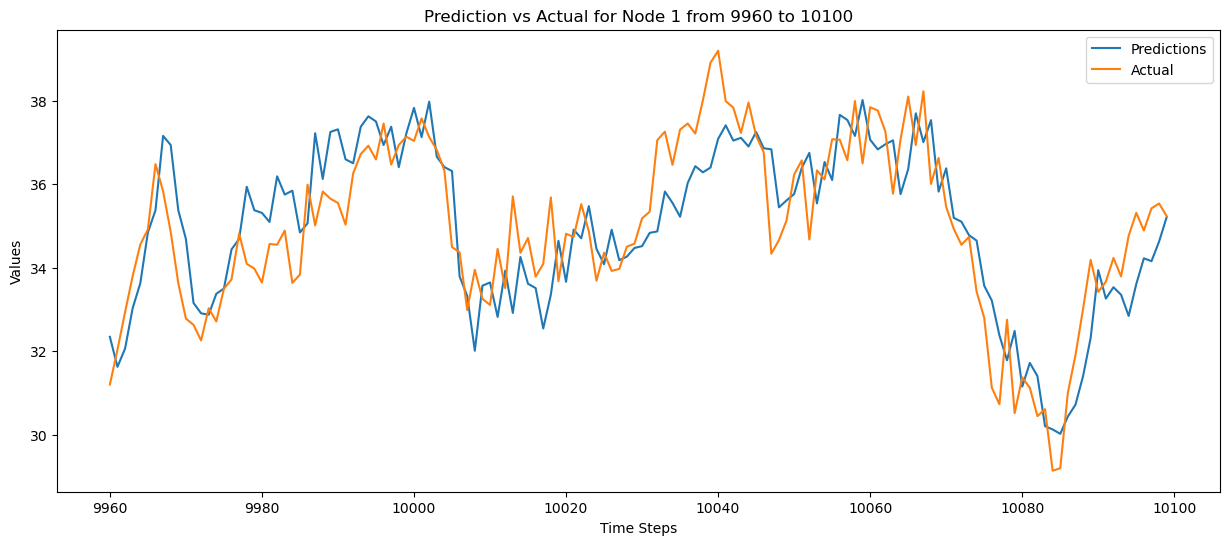

In [36]:
lstm_trainer.plot_range(9960, 10100, 1)

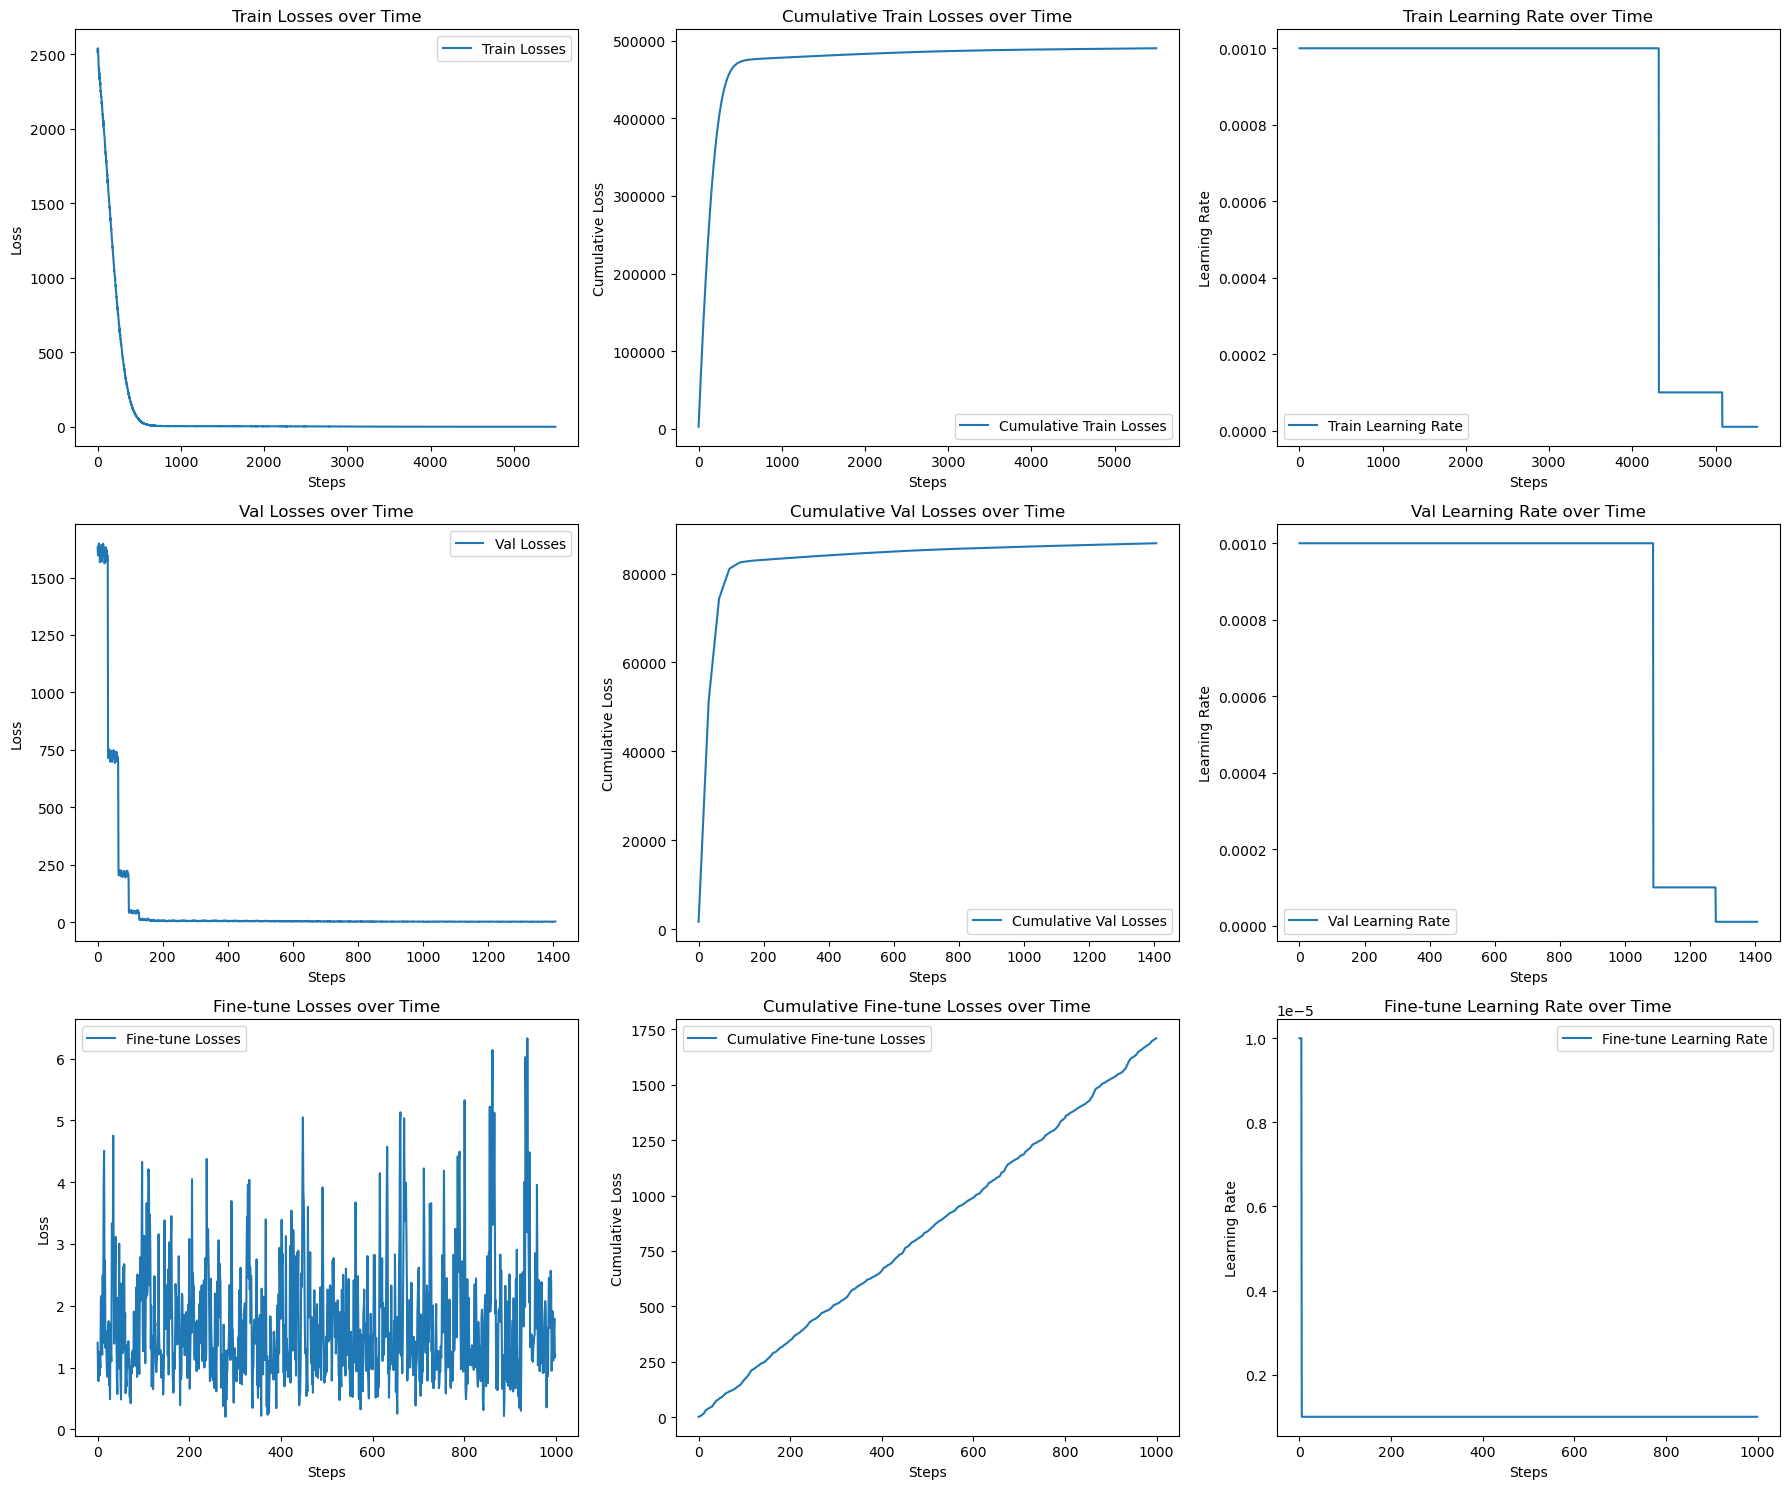

In [37]:
lstm_trainer.plot_all_losses_and_lr_0()  # 绘制损失和学习率曲线

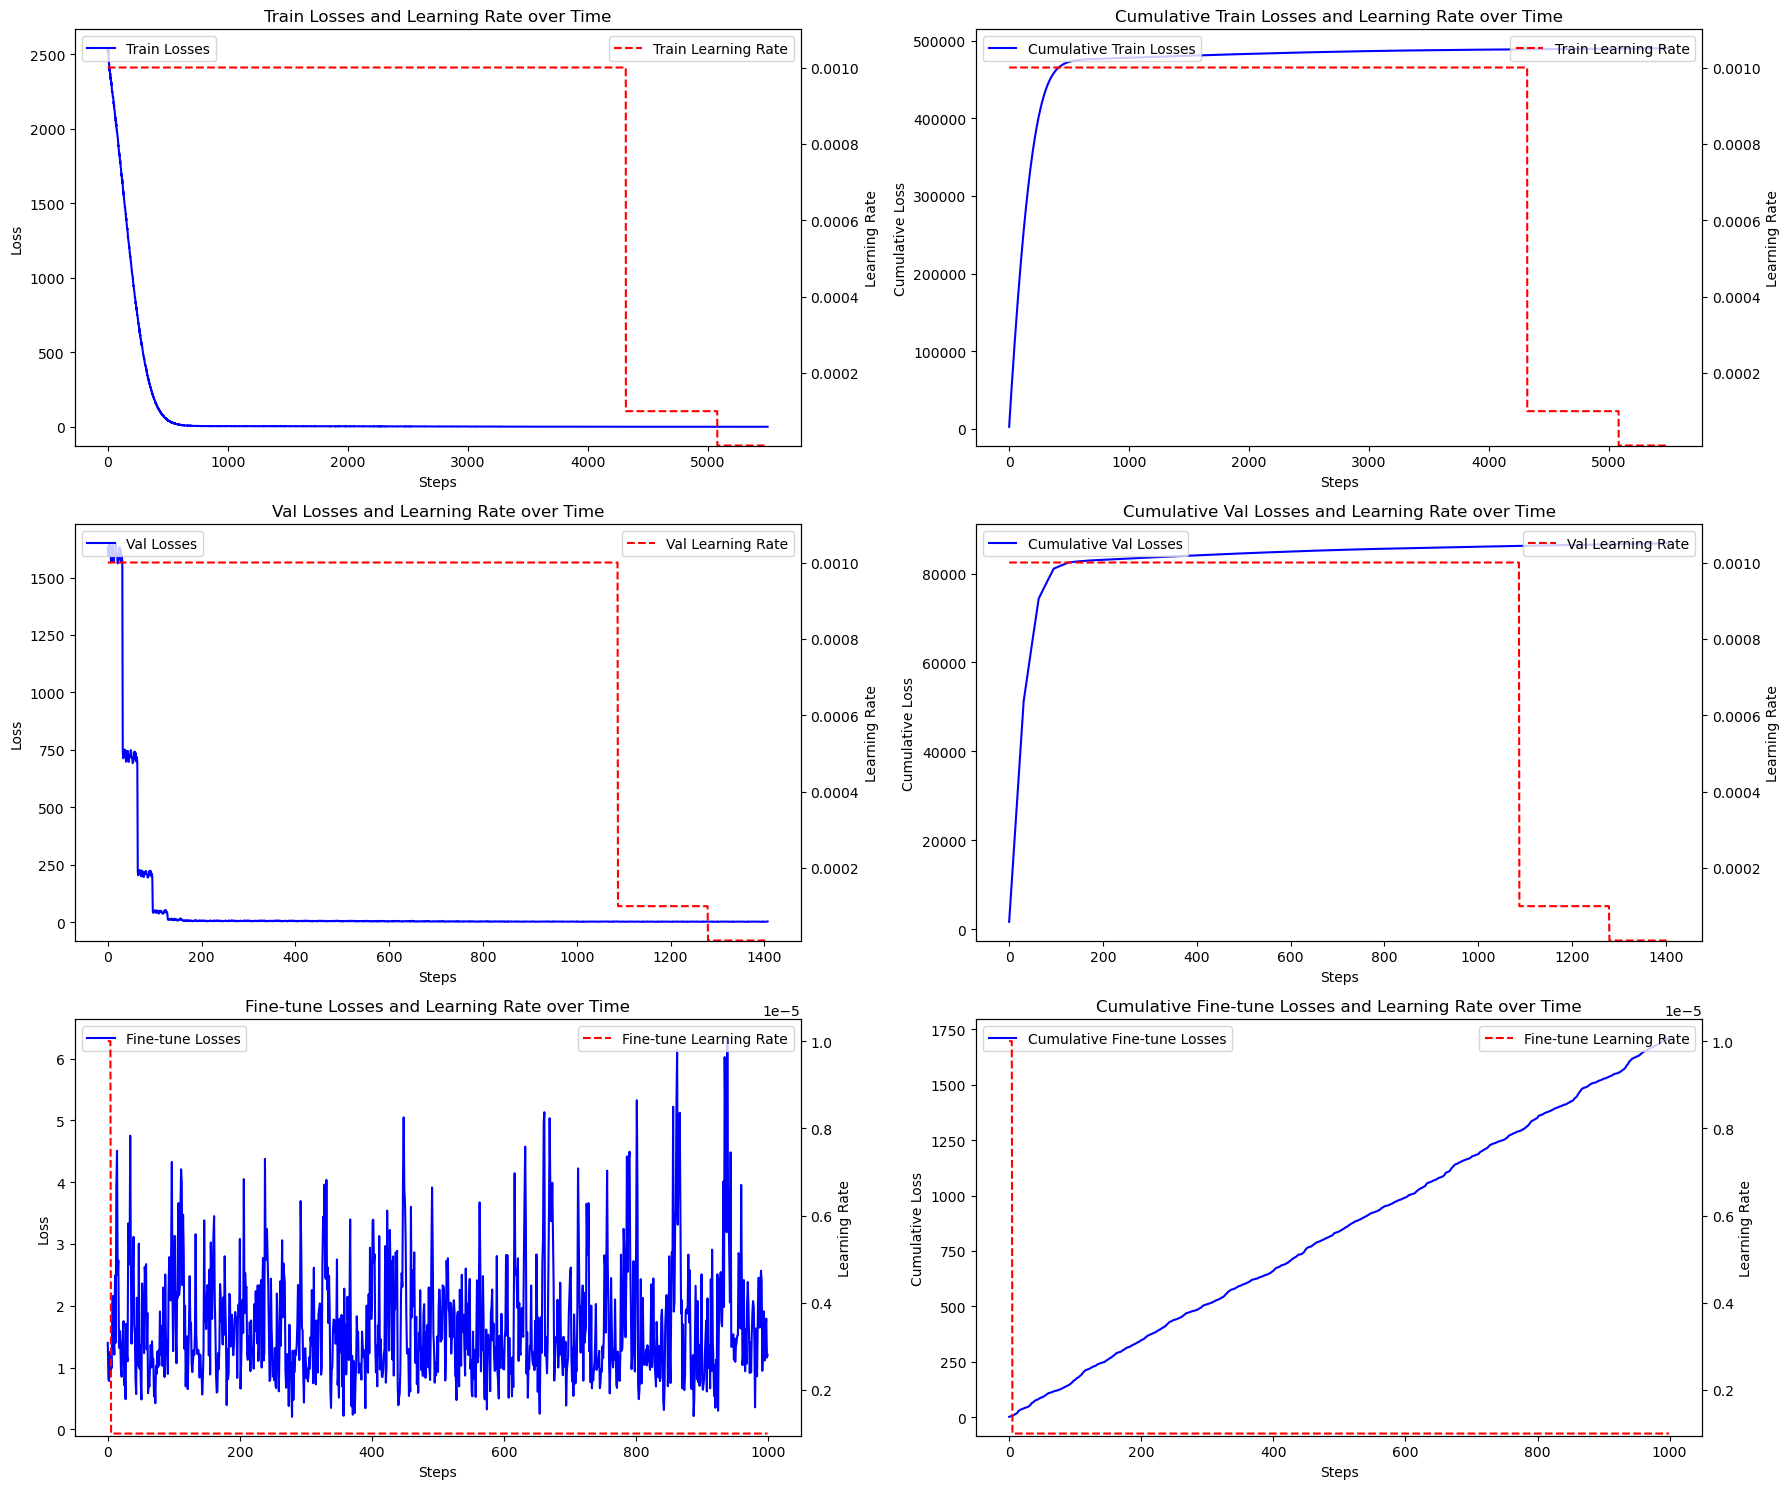

In [38]:
lstm_trainer.plot_all_losses_and_lr_1(left_log_scale=False, right_log_scale=False)  # 绘制损失和学习率曲线

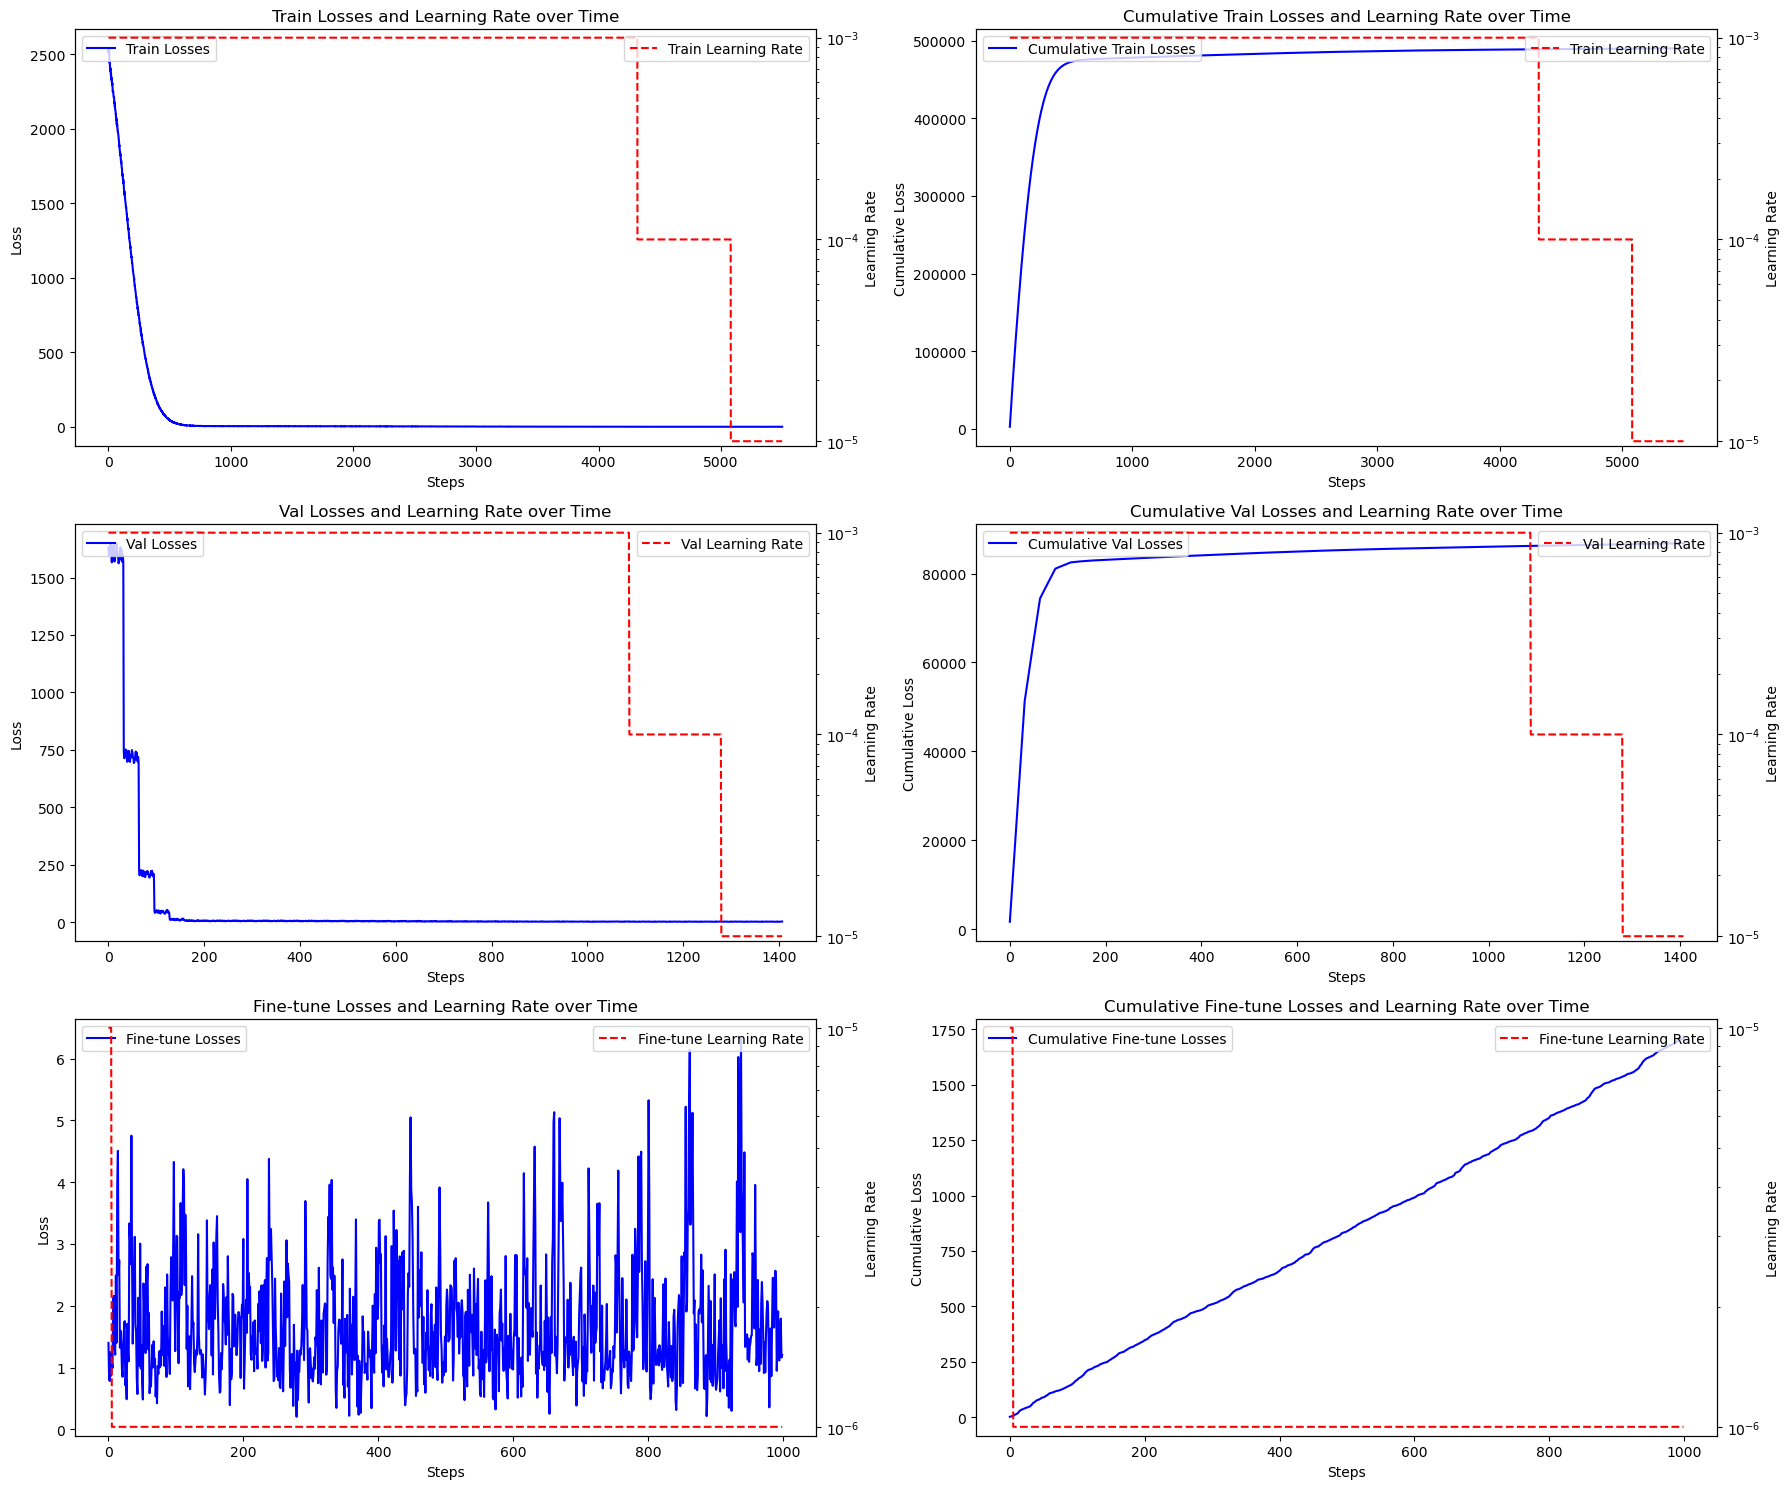

In [39]:
lstm_trainer.plot_all_losses_and_lr_1(left_log_scale=False, right_log_scale=True)  # 绘制损失和学习率曲线

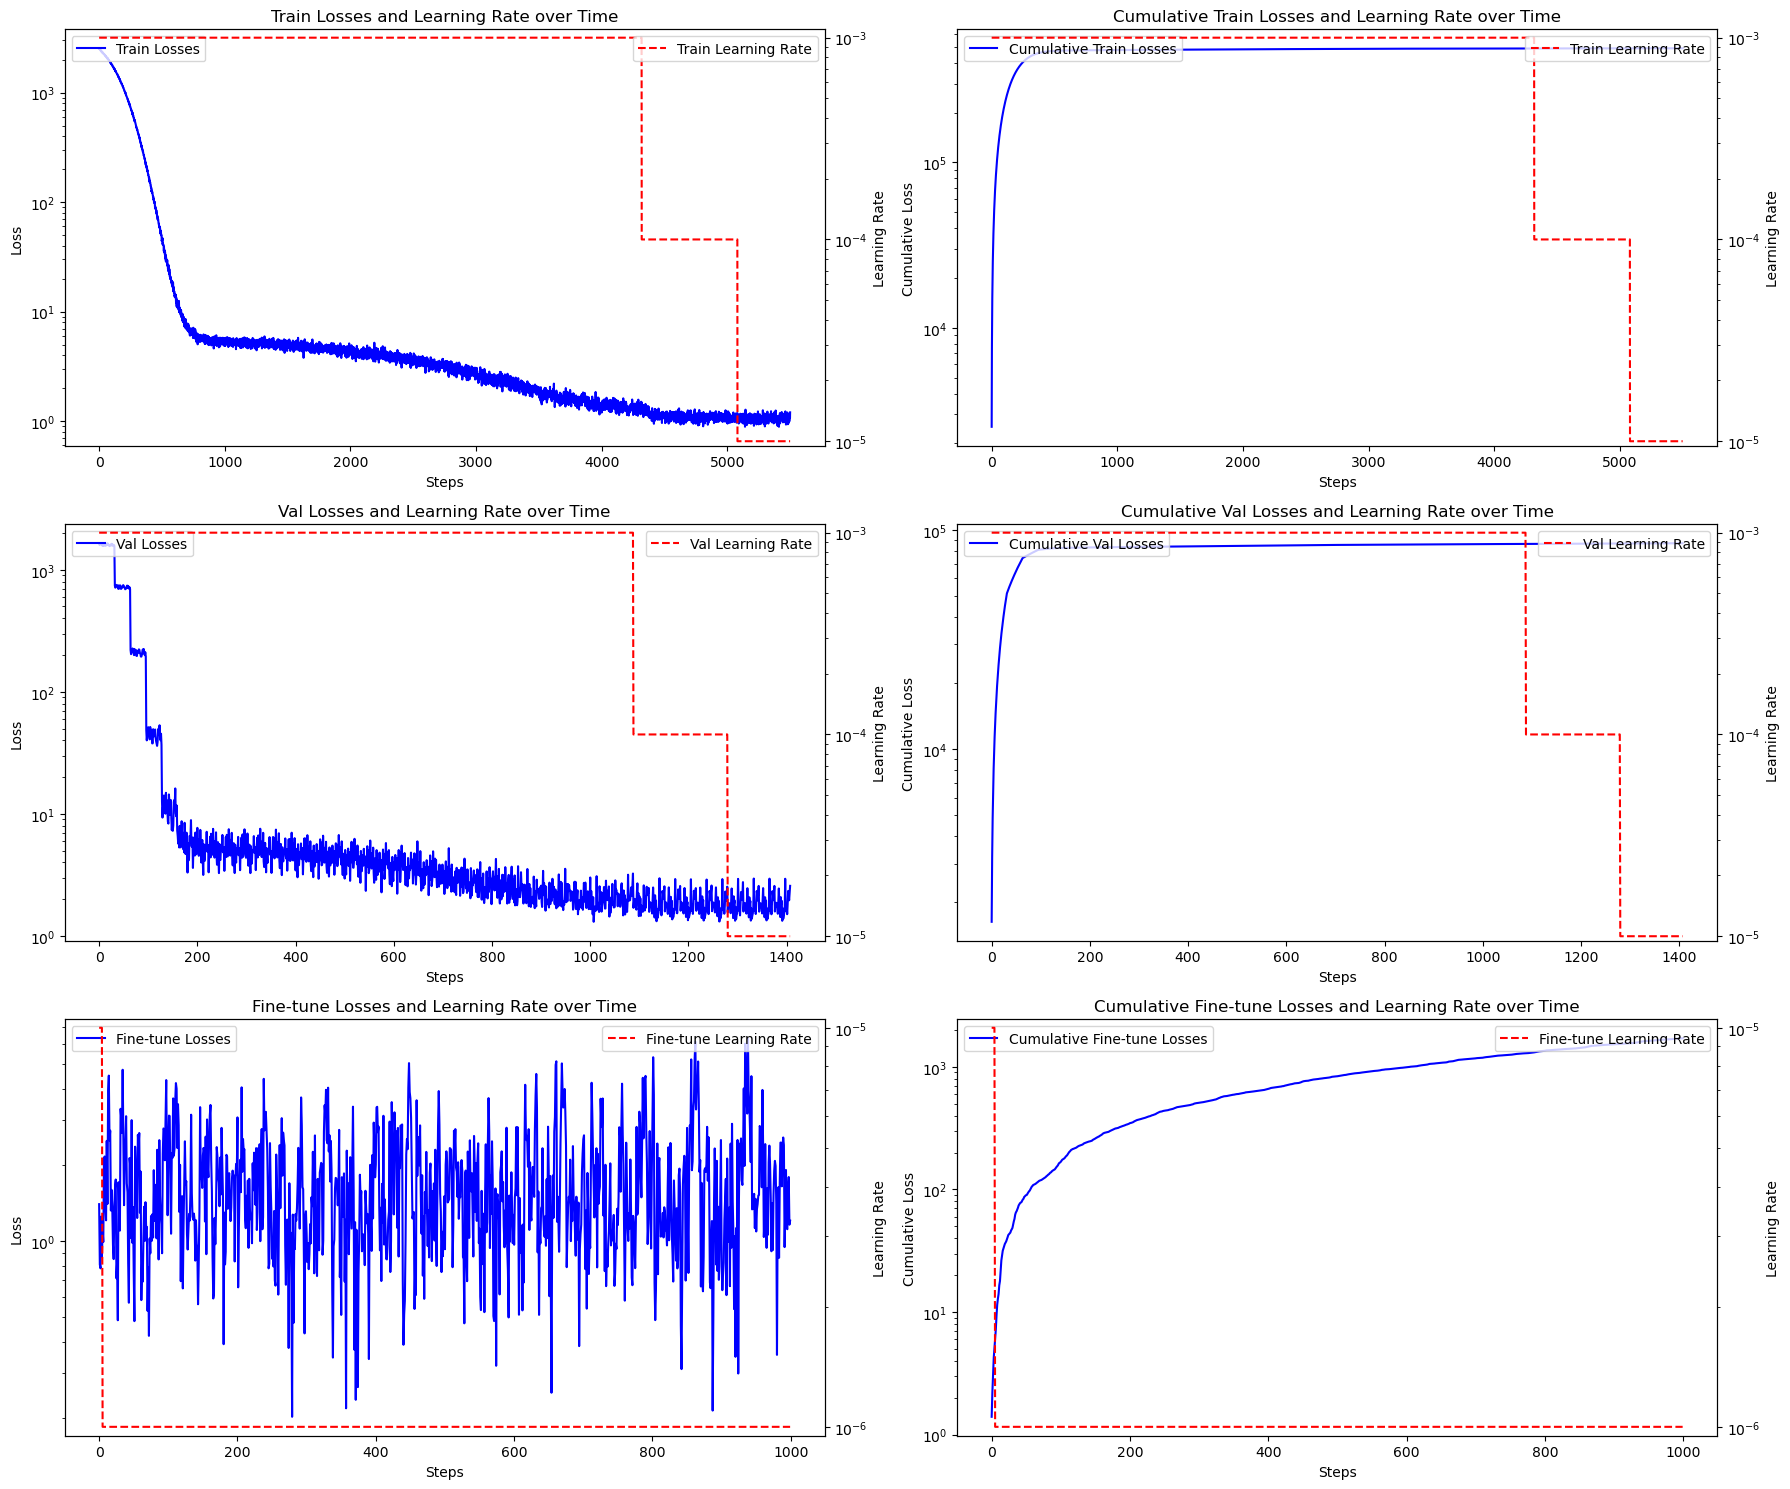

In [40]:
lstm_trainer.plot_all_losses_and_lr_1(left_log_scale=True, right_log_scale=True)  # 绘制损失和学习率曲线

In [41]:
np.savetxt('../Data/LSTM_predictions.csv', lstm_trainer.test_predictions.detach().cpu().numpy().T, delimiter=',')
